In [420]:
#To access gdrive files in google colab

#%cd ..
#from google.colab import drive
#drive.mount('/content/gdrive')

In [421]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

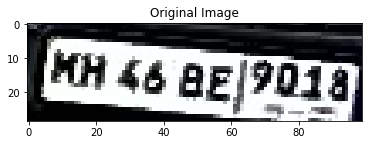

In [422]:
#reading and displaying of image
image = cv2.imread('/content/gdrive/My Drive/croped_num_plate/4T.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #converted to rgb to get corrected image even after reading it directly
plt.imshow(image)
plt.title('Original Image')
plt.show()

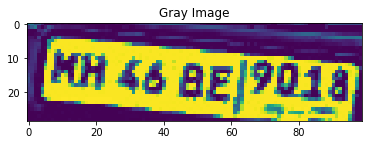

In [423]:
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) #to get gray scale image
kernel = np.ones((5, 5), np.float32) / 15
#filtered = cv2.filter2D(gray, -1, kernel) #Blurred image
plt.imshow(gray)
plt.title('Gray Image')
plt.show()

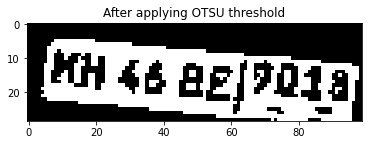

In [424]:
# Otsu Threshold for binary classification of the image; i.e. classify each pixel as either black or white.
ret, thresh = cv2.threshold(gray, 250, 255, cv2.THRESH_OTSU) 
plt.imshow(cv2.cvtColor(thresh, cv2.COLOR_BGR2RGB))
plt.title('After applying OTSU threshold')
plt.show()

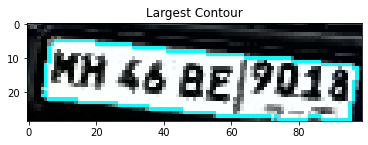

In [425]:
image_copy = image.copy() #copy of original image

# Contour Detection
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
cnt = sorted(contours, key=cv2.contourArea, reverse=True)[0] 
cv2.drawContours(image_copy, cnt, -1, (0, 255, 255), 1)
plt.title('Largest Contour')
plt.imshow(image_copy)
plt.show()

In [426]:
#epsilon detect curved parts in an image 
#cv2.approxPolyDP() uses Douglas-Peucker algorithm to approximate a curve or a polygon with fewer vertices 
#so that the distance between them is less than epsilon. (to get good approximation of contour)
epsilon = 0.05 * cv2.arcLength(cnt, True) #2% of the contour arc length
approx_corners = cv2.approxPolyDP(cnt, epsilon, True) #corner detection
#approx_corners = sorted(np.concatenate(approx_corners).tolist())
cv2.drawContours(image_copy, approx_corners, -1, (255, 255, 0), 5)
approx_corners = np.concatenate(approx_corners).tolist()  
print(approx_corners)

[[6, 7], [6, 22], [95, 28], [95, 12]]


In [427]:
print('\nThe corner points are ...\n')
for index, c in enumerate(approx_corners):
        character = chr(65 + index)
        print(character, ':', c)
        cv2.putText(image_copy, character, tuple(c), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)


The corner points are ...

A : [6, 7]
B : [6, 22]
C : [95, 28]
D : [95, 12]


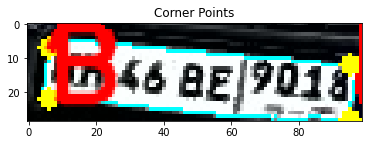

In [428]:
#Displaying corner points
approx_corners = [approx_corners[i] for i in [0, 2, 1, 3]]
plt.imshow(image_copy)
plt.title('Corner Points')
plt.show()

In [429]:
#To get height and width of target rectangle maximum of the 2 heights and 2 width calculated 
w1 = np.sqrt((approx_corners[0][0] - approx_corners[1][0]) ** 2 + (approx_corners[0][1] - approx_corners[1][1]) ** 2)
w2 = np.sqrt((approx_corners[2][0] - approx_corners[3][0]) ** 2 + (approx_corners[2][1] - approx_corners[3][1]) ** 2)
w = max(int(w1), int(w2))

h1 = np.sqrt((approx_corners[0][0] - approx_corners[2][0]) ** 2 + (approx_corners[0][1] - approx_corners[2][1]) ** 2)
h2 = np.sqrt((approx_corners[1][0] - approx_corners[3][0]) ** 2 + (approx_corners[1][1] - approx_corners[3][1]) ** 2)
h = max(int(h1), int(h2))

#setting of destination corner points  
#destination_corners = np.float32([(0, 0), (w - 1, 0), (0, h - 1), (w - 1, h - 1)])#According to document destination points

#destination_corners = np.float32([(w - 1, 0), (0, h - 1), (w - 1, h - 1), (0, 0)]) #need flipping with +1 (output is correct but some part is missing)

#destination_corners = np.float32([(0, h - 1), (w - 1, 0), (w - 1, h - 1), (0, 0)]) #need to rotate image 90degree clockwise (but some images are tilted)   

destination_corners = np.float32([(0, 0), (w - 1, h - 1), (0, h - 1), (w - 1, 0)])#no flipping and rotation require

print('\nThe destination points are: \n')
for index, c in enumerate(destination_corners):
    character = chr(65 + index) + "'"
    print(character, ':', c)
        
    print('\nThe approximated height and width of the original image is: \n', (h, w))


The destination points are: 

A' : [0. 0.]

The approximated height and width of the original image is: 
 (16, 91)
B' : [90. 15.]

The approximated height and width of the original image is: 
 (16, 91)
C' : [ 0. 15.]

The approximated height and width of the original image is: 
 (16, 91)
D' : [90.  0.]

The approximated height and width of the original image is: 
 (16, 91)



The homography matrix is: 
 [[ 1.08352144e+00  7.35348612e-17 -6.50112867e+00]
 [-5.64334086e-02  1.00451467e+00 -6.69300226e+00]
 [ 7.52445448e-04 -9.38506647e-20  1.00000000e+00]]


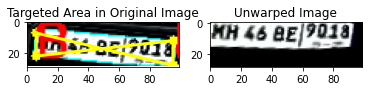

In [430]:
h, w = image.shape[:2] #height and width of original image

#RANSAC algorithm used for matrix calculation
H, _ = cv2.findHomography(np.float32(approx_corners), destination_corners, method=cv2.RANSAC, ransacReprojThreshold=3.0)
print('\nThe homography matrix is: \n', H)
un_warped = cv2.warpPerspective(image, H, (w, h), flags=cv2.INTER_LINEAR)

# plot

f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(image_copy)
x = [approx_corners[0][0], approx_corners[2][0], approx_corners[3][0], approx_corners[1][0], approx_corners[0][0]]
y = [approx_corners[0][1], approx_corners[2][1], approx_corners[3][1], approx_corners[1][1], approx_corners[0][1]]
#x = [approx_corners[0][0], approx_corners[1][0], approx_corners[2][0], approx_corners[3][0], approx_corners[0][0]] 
#y = [approx_corners[0][1], approx_corners[1][1], approx_corners[2][1], approx_corners[3][1], approx_corners[0][1]]
ax1.plot(x, y, color='yellow', linewidth=3)
ax1.set_ylim([h, 0])
ax1.set_xlim([0, w])
ax1.set_title('Targeted Area in Original Image')
ax2.imshow(un_warped)
ax2.set_title('Unwarped Image')
plt.show()

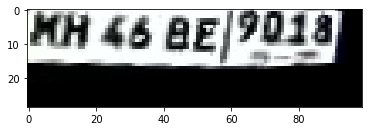

In [431]:
cropped = un_warped[0:h, 0:w]
plt.imshow(cropped)
plt.show()

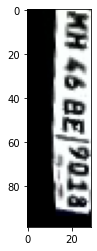

In [432]:
# Rotation require for some images
rotate = cv2.rotate(cropped, cv2.ROTATE_90_CLOCKWISE)

plt.imshow(rotate)

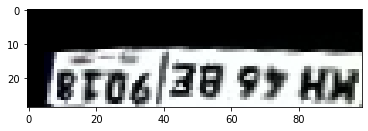

In [433]:
#for some images
rotate = cv2.rotate(rotate, cv2.ROTATE_90_CLOCKWISE)

plt.imshow(rotate)

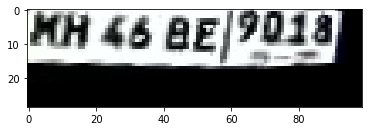

In [434]:
# Flipping require for some images
#In order to get straight image, it is flipped continuously till it become straight 
cropped = cv2.flip(rotate, -1)
plt.imshow(cropped)

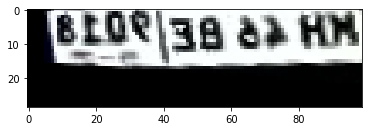

In [435]:
#In order to get straight image, it is flipped continuously till it become straight 
cropped = cv2.flip(cropped, 1)
plt.imshow(cropped)